In [1]:
## 导入必要的包
import numpy as np
import scipy
import matplotlib.pyplot as plt
from scipy import ndimage

# 一种储存数据的形式
import h5py

# 用于处理图片
from PIL import  Image

# 使用绘图工具时直接讲图绘制在notebook而不是新启一个Window
%matplotlib inline

In [2]:
## 定义数据导入方式
def load_dataset():
    train_dataset = h5py.File('/home/kelly/project/YIQIXUE_AI/data/week1/train_catvnoncat.h5', "r")
    train_set_x_orig = np.array(train_dataset["train_set_x"][:]) # 得到训练集的特征
    train_set_y_orig = np.array(train_dataset["train_set_y"][:]) # 得到训练集的Labels

    test_dataset = h5py.File('/home/kelly/project/YIQIXUE_AI/data/week1/test_catvnoncat.h5', "r")
    test_set_x_orig = np.array(test_dataset["test_set_x"][:]) # 得到测试集的特征
    test_set_y_orig = np.array(test_dataset["test_set_y"][:]) # 得到测试机的Labels

    classes = np.array(test_dataset["list_classes"][:]) # 得到分类的枚举值
    
    train_set_y_orig = train_set_y_orig.reshape((1, train_set_y_orig.shape[0]))
    test_set_y_orig = test_set_y_orig.reshape((1, test_set_y_orig.shape[0]))
    
    return train_set_x_orig, train_set_y_orig, test_set_x_orig, test_set_y_orig, classes

In [3]:
## 读取训练数据（都是像素点）
train_set_x_orig, train_set_y, test_set_x_orig, test_set_y, classes = load_dataset()

In [13]:
## 简单查看数据分布
print "一共有{}个训练集和{}个测试集!".format(len(train_set_x_orig), len(test_set_x_orig))
print "训练集的形状是这样的{}".format(train_set_x_orig.shape)

一共有209个训练集和50个测试集!
训练集的形状是这样的(209, 64, 64, 3)


y = [0], it's a 'non-cat' picture.


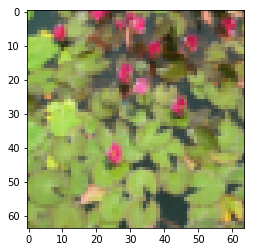

In [10]:
## 随便取出一个不是猫的像素点看看图片
index = 18
example = train_set_x_orig[index]
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

y = [1], it's a 'cat' picture.


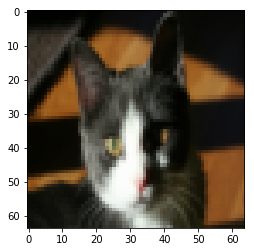

In [11]:
## 随便取出一个是猫的像素点看看图片
index = 19
example = train_set_x_orig[index]
plt.imshow(train_set_x_orig[index])
print ("y = " + str(train_set_y[:, index]) + ", it's a '" + classes[np.squeeze(train_set_y[:, index])].decode("utf-8") +  "' picture.")

In [14]:
## 分别取出训练集和测试并对整体数据进行一个观察
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
num_px = train_set_x_orig.shape[2]

print ("训练集的数量是: m_train = " + str(m_train))
print ("测试集的数量是: m_test = " + str(m_test))
print ("每一个图片的高和宽是: num_px = " + str(num_px))
print ("每一个图片的尺寸是: (" + str(num_px) + ", " + str(num_px) + ", 3)")
print ("train_set_x shape: " + str(train_set_x_orig.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x shape: " + str(test_set_x_orig.shape))
print ("test_set_y shape: " + str(test_set_y.shape))

训练集的数量是: m_train = 209
测试集的数量是: m_test = 50
每一个图片的高和宽是: num_px = 64
每一个图片的尺寸是: (64, 64, 3)
train_set_x shape: (209, 64, 64, 3)
train_set_y shape: (1, 209)
test_set_x shape: (50, 64, 64, 3)
test_set_y shape: (1, 50)


In [15]:
## 将测试集和训练集的shape做转换，让其可以做训练，即flatten，其实就是num_px * num_px * 3（channel）
train_set_x_flatten = train_set_x_orig.reshape(train_set_x_orig.shape[0], -1).T
test_set_x_flatten = test_set_x_orig.reshape(test_set_x_orig.shape[0], -1).T

print ("train_set_x_flatten shape: " + str(train_set_x_flatten.shape))
print ("train_set_y shape: " + str(train_set_y.shape))
print ("test_set_x_flatten shape: " + str(test_set_x_flatten.shape))
print ("test_set_y shape: " + str(test_set_y.shape))
print ("sanity check after reshaping: " + str(train_set_x_flatten[0:5,0]))

train_set_x_flatten shape: (12288, 209)
train_set_y shape: (1, 209)
test_set_x_flatten shape: (12288, 50)
test_set_y shape: (1, 50)
sanity check after reshaping: [17 31 56 22 33]


In [16]:
## 对像素做归一化处理,注意要是float格式
## 通常处理图片数据有三种常见操作
# 确定问题的维度、形状：多少个训练集、多少个测试集，像素是几乘几的
# 对数据集做处理，保证每一个样本数据是一个向量，向量的维度一定是(num_px * num_px * 3, 1)
# 对数据做归一化处理，即每个像素/255
train_set_x = train_set_x_flatten/255.
test_set_x = test_set_x_flatten/255.

## 